In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics

# Change your file name here

In [ ]:
# read and clean data

it_df = pd.read_csv("i-t_example1.txt", header=0)    # "i-t_example1.txt" is converted from CHI software directly
it_df = it_df.drop(range(0,13))   # drop the unused data
it_df = it_df.reset_index(drop=True)   # reset it_df index
it_df.columns = ['Time(s)', 'Current(A)']   # Renaming the columns name

In [ ]:
# display all rows

# pd.set_option('display.max_rows', None)
# it_df

In [ ]:
# Convert data from string to float type
it_df = it_df.astype('float')

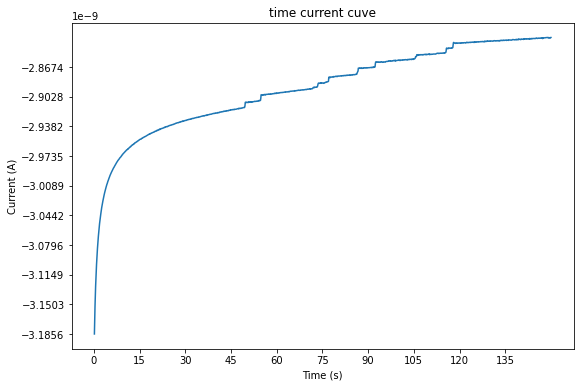

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(it_df['Time(s)'], it_df['Current(A)'])

# Set the interval of xticks.
listOf_Xticks = np.arange(0, max(it_df['Time(s)']), max(it_df['Time(s)'])/10)
plt.xticks(listOf_Xticks)
# Set the interval of yticks.
listOf_Yticks = np.arange(min(it_df['Current(A)']), max(it_df['Current(A)']), abs(max(it_df['Current(A)'])-min(it_df['Current(A)']))/10)
plt.yticks(listOf_Yticks)

# Set the x and y label
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
# Giving title to the plot
plt.title('time current cuve')

plt.show()

# Set parameters here

In [ ]:
# Set parameters here
start_analysis_time = 40    # Set when to start analysis in order to get rid of unstable data at beginning. The unit is second

sample_interval = 0.1    # Set the sample interval. For CHI instrument, this is your 'Sample Interval(sec)'
threshold_slope_ratio = 15   # Default is 10. Set this ratio to get slope threshold

In [ ]:
# drop the beginning data

start_analysis_index_list = it_df.index[it_df['Time(s)'] == float(start_analysis_time)].to_list()   # find index based on time
start_analysis_index = start_analysis_index_list[0]
it_df = it_df.drop(range(0, start_analysis_index))   # drop the beginning data
it_df = it_df.reset_index(drop=True)   # reset it_df index

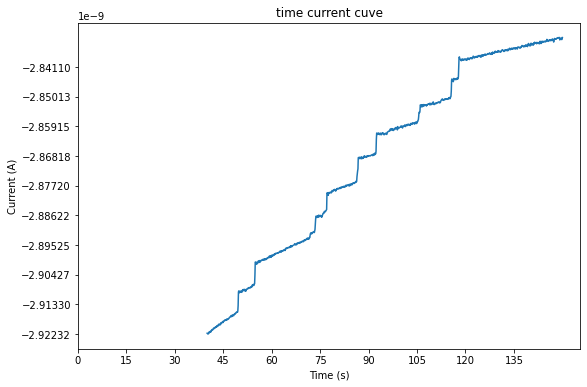

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(it_df['Time(s)'], it_df['Current(A)'])

# Set the interval of xticks.
listOf_Xticks = np.arange(0, max(it_df['Time(s)']), max(it_df['Time(s)'])/10)
plt.xticks(listOf_Xticks)
# Set the interval of yticks.
listOf_Yticks = np.arange(min(it_df['Current(A)']), max(it_df['Current(A)']), abs(max(it_df['Current(A)'])-min(it_df['Current(A)']))/10)
plt.yticks(listOf_Yticks)

# Set the x and y label
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
# Giving title to the plot
plt.title('time current cuve')

plt.show()

In [ ]:
slope_list = []
for i in range(11):
    current_next = float(it_df.iloc[i+1, 1])
    current_now = float(it_df.iloc[i, 1])
    time_next=float(it_df.iloc[i+1,0])
    time_now=float(it_df.iloc[i-1,0])

    dif_current = current_next - current_now
    dif_time=time_next - time_now
    slope = dif_current/dif_time
    slope = abs(slope)
    slope_list.append(slope)

# We took absolute median value of first 11 points as slope
slope =  abs(statistics.median(slope_list))
threshold_slope = slope * threshold_slope_ratio
threshold_slope   # slope that is larger than threshold_slope will considered step height

5.99999999998956e-12

In [ ]:
# read block step height

index_pre = -1
blockDF = pd.DataFrame(columns = ['time(s)', 'step height(A)'])

for index, row in it_df.iterrows():
    if index == len(it_df['Time(s)'])-1:
        break
    else: 
        current_next = float(it_df.iloc[index+1, 1])
        current_now = float(it_df.iloc[index, 1])
        time_next=float(it_df.iloc[index+1,0])
        time_now=float(it_df.iloc[index-1,0])
        
        dif_current = current_next - current_now
        dif_time=time_next - time_now
        slope = dif_current/dif_time
        one_step_height = dif_current
        
        if slope > threshold_slope:
            if index - index_pre == 1:
                step_height = step_height + one_step_height
            else:
                step_height= dif_current
            oneStepHeight_df = pd.DataFrame([[it_df.iloc[index,0], step_height]], columns=['time(s)', 'step height(A)'])
            blockDF = pd.concat([blockDF, oneStepHeight_df], ignore_index = True)
        else:
            step_height = 0       
        index_pre = index_pre + 1

# blockDF

In [ ]:
# combine closed step height

blockDF_cumu = blockDF.copy()
for index, row in blockDF.iterrows():
    if index == 0:
        continue
    else:
        time1 = float(blockDF.iloc[index-1,0])
        time2 = float(blockDF.iloc[index,0])
        time_dif = round(time2-time1, 2)
        if time_dif == float(sample_interval):
            step_height = float(blockDF_cumu.iloc[index-1,1]) + float(blockDF.iloc[index,1])
            blockDF_cumu['step height(A)'].iloc[index] = step_height
block2_DF = blockDF_cumu.copy()

for index, row in blockDF_cumu.iterrows():
    if index == 0:
        continue
    else:
        time1 = float(blockDF_cumu.iloc[index-1,0])
        time2 = float(blockDF_cumu.iloc[index,0])
        time_dif = round(time2-time1, 2)
        if time_dif == float(sample_interval):  
            block2_DF = block2_DF.drop([index-1])
            
block2_DF = block2_DF.reset_index(drop=True)
block2_DF

,time(s),step height(A)
0,49.5998,7.370000e-12
1,54.7997,9.140000e-12
2,73.4995,4.960000e-12
3,76.9994,4.720000e-12
4,86.2993,1.430000e-12
5,86.6992,3.410000e-12
6,92.3992,9.250000e-12
7,105.4990,1.360000e-12
8,105.8990,1.870000e-12
9,115.5990,6.480000e-12


In [ ]:
block2_DF.to_excel('block events.xlsx')